<a href="https://colab.research.google.com/github/DivyaAmirtharaj/cs262-finalproject/blob/main/smoke_detection_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

## Prepare Data


To train a TensorFlow2 Object Detection Model, we need TFRecord and label_map files. Roboflow creates these files for us!

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll split the dataset into "train" and "test".

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/). On export, select "Tensorflow TFRecord" for the first link and "COCO JSON" as the second link below.

![](https://i.imgur.com/ZwMdcbY.png)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="kurHDAP4tAun3nyyYi4d")
project = rf.workspace("wildfire-xpwrf").project("wildfire-4tdl8")

# Specify the desired version of the dataset and the output directory
output_directory = "/content/Wildfire"
dataset = project.version(2).download("tfrecord", output_directory)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstall

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/Wildfire in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 121.09it/s]


# 2. Train

_Note that this section is based on the [MobileNetSSDv2 Notebook](https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a). This is because TensorFlow Lite is independent of the model used, so we're picking a simple and lightweight solution._

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 10000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'batch_size': 12
    },
    'faster_rcnn': { # Update to make compatible with TF2
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu',
        'pipeline_file': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config',
        'batch_size': 12
    },
    'efficientdet': { # Update to make compatible with TF2
        'model_name': 'ssd_efficientdet_d4_1024x1024_coco17_tpu-32',
        'pipeline_file': 'ssd_efficientdet_d4_1024x1024_coco17_tpu-32.config',
        'batch_size': 8
    },
}


# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 9.70 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install tensorflow_io

!pip install tf-models-official

# TF 2.13.0 is the only compatible version
!pip uninstall -y tensorflow
!pip install tensorflow==2.13.0

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
E: Unable to locate package python-pil
E: Unable to locate package python-lxml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.9 M

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
!cp -r /content/Wildfire/train/ /content/tensorflow-object-detection-faster-rcnn/data/
!cp -r /content/Wildfire/test/ /content/tensorflow-object-detection-faster-rcnn/data/

In [ ]:
# training set
%ls train

fire_label_map.pbtxt  fire.tfrecord


In [ ]:
# test set
%ls test

fire_label_map.pbtxt  fire.tfrecord


In [ ]:
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/fire.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/fire.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/fire_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
print(MODEL_FILE)
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
print(DOWNLOAD_BASE)
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
http://download.tensorflow.org/models/object_detection/tf2/20200711/


In [ ]:
import tensorflow as tf

saved_model_path = os.path.join(DEST_DIR, "saved_model/")

# Load the SavedModel
loaded_model = tf.saved_model.load(saved_model_path)

# Create a checkpoint from the loaded model
ckpt = tf.train.Checkpoint(model=loaded_model)

# Save the checkpoint to a new file
ckpt_path = ckpt.save(os.path.join(DEST_DIR, "checkpoint/model.ckpt"))
fine_tune_checkpoint = ckpt_path

In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 24K
drwxr-x---  4 345018 89939 4.0K Jul 11  2020 .
drwxr-xr-x 23 root   root  4.0K Dec  4 17:14 ..
drwxr-x---  2 345018 89939 4.0K Dec  4 17:15 checkpoint
-rw-r-----  1 345018 89939 4.5K Jul 11  2020 pipeline.config
drwxr-x---  3 345018 89939 4.0K Jul 10  2020 saved_model


## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/configs/tf2/', pipeline_file)
print(pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config


In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

train_record = "/content/tensorflow-object-detection-faster-rcnn/data/train/fire.tfrecord"
train_label_map = "/content/tensorflow-object-detection-faster-rcnn/data/train/fire_label_map.pbtxt"

test_record = "/content/tensorflow-object-detection-faster-rcnn/data/test/fire.tfrecord"
test_label_map = "/content/tensorflow-object-detection-faster-rcnn/data/test/fire_label_map.pbtxt"

num_classes = get_num_classes(label_map_pbtxt_fname)

with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:

    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    s = re.sub('fine_tune_checkpoint_type: ".*?"',
               'fine_tune_checkpoint_type: "detection"', s)

    # label_map_path
    s = re.sub(r'(train_input_reader: {[\s\S]*?label_map_path: ")[^"]*(")',
               r'\1{}\2'.format(train_label_map), s)
    s = re.sub(r'(eval_input_reader: {[\s\S]*?label_map_path: ")[^"]*(")',
               r'\1{}\2'.format(test_label_map), s)

    # tfrecord paths
    s = re.sub(
        r'(train_input_reader: {\s+label_map_path: ".*?"\s+tf_record_input_reader {\s+input_path: ").*?(")',
        r'\1{}\2'.format(train_record), s)
    s = re.sub(
        r'(eval_input_reader: {\s+label_map_path: ".*?"\s+tf_record_input_reader {\s+input_path: ").*?(")',
        r'\1{}\2'.format(test_record), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 FPN-lite (go/fpn-lite) feature extractor, shared box
# predictor and focal loss (a mobile version of Retinanet).
# Retinanet: see Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 22.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {

In [ ]:
model_dir = '../../../content/training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)


## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2023-12-04 01:33:53--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  4.72MB/s    in 2.8s    

2023-12-04 01:33:57 (4.72 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://4721-35-187-232-128.ngrok.io


## Train the model

In [ ]:
!pip install lvis
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
 'Loss/regularization_loss': 0.09877418,
 'Loss/total_loss': 0.16945378,
 'learning_rate': 0.060515966}
I1204 04:09:48.970816 139095377482368 model_lib_v2.py:708] {'Loss/classification_loss': 0.052091196,
 'Loss/localization_loss': 0.018588409,
 'Loss/regularization_loss': 0.09877418,
 'Loss/total_loss': 0.16945378,
 'learning_rate': 0.060515966}
INFO:tensorflow:Step 17200 per-step time 0.156s
I1204 04:10:04.604952 139095377482368 model_lib_v2.py:705] Step 17200 per-step time 0.156s
INFO:tensorflow:{'Loss/classification_loss': 0.05848804,
 'Loss/localization_loss': 0.03994205,
 'Loss/regularization_loss': 0.098428376,
 'Loss/total_loss': 0.19685847,
 'learning_rate': 0.060295396}
I1204 04:10:04.605376 139095377482368 model_lib_v2.py:708] {'Loss/classification_loss': 0.05848804,
 'Loss/localization_loss': 0.03994205,
 'Loss/regularization_loss': 0.098428376,
 'Loss/total_loss': 0.19685847,
 'learning_rate': 0.060295396}
INFO:tensorflow:

In [ ]:
# Import necessary libraries
import tensorflow as tf
import object_detection

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Print Object Detection API version
# Object Detection API does not have a __version__ attribute typically,
# so we try to get its version info from its metadata if available
try:
    import pkg_resources
    od_version = pkg_resources.get_distribution("object-detection").version
    print("Object Detection API version:", od_version)
except Exception as e:
    print(e)
    print("Object Detection API version info not available")


TensorFlow version: 2.13.0
The 'object-detection' distribution was not found and is required by the application
Object Detection API version info not available


In [ ]:
!ls {model_dir}

train


## Exporting Trained Inference Graphs
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. We do this again for TFLite. This can be done as follows:

In [ ]:
%cd /content/models/research

import re
import numpy as np

output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/models/research


ValueError: ignored

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta   tflite
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
print(pb_fname)
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Feb 10 16:34 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# # Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1v4Dua3btdHLH8Z38YjA1oGgAflzO1CcA


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!tar cfz fine_tuned_model.tar.gz fine_tuned_model
from google.colab import files
files.download('fine_tuned_model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [ ]:
!cp -r /content/test/test/ /content/tensorflow-object-detection-faster-rcnn/

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/test/000073_jpg.rf.7427fbe099a315ac8c416c5c42456f5d.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/000047_jpg.rf.7729e278711ed917ffcadcb3b715e928.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/_annotations.coco.json', '/content/tensorflow-object-detection-faster-rcnn/test/000084_jpg.rf.00246d351e5976c8498b963ff87f44b7.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/000054_jpg.rf.f0a070600859155d81aa42513190709c.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/000097_jpg.rf.5af0bfda9032d1ce0ef23f0d19a04bd6.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/000034_jpg.rf.8181d7cc3b55440d0cc3afeffeef0ae0.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/000008_jpg.rf.dd35c34c49239791f665ecb6e4c1f049.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/000098_jpg.rf.1f996321180f2e95dcfd1d9aaee48556.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/

In [ ]:
!ls /content/tensorflow-object-detection-faster-rcnn/

data			    requirements.txt
deploy			    resize_images.py
generate_tfrecord.py	    tensorflow_object_detection_training_colab.ipynb
LICENSE			    test
local_inference_test.ipynb  Tutorial_Faster_RCNN.ipynb
local_inference_test.py     Tutorial_Mobilenet.ipynb
README.md		    xml_to_csv.py


In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

UnidentifiedImageError: ignored

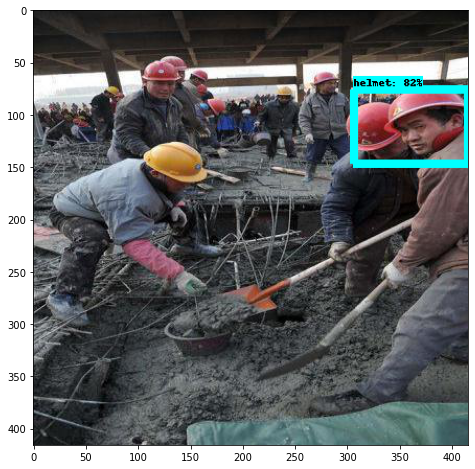

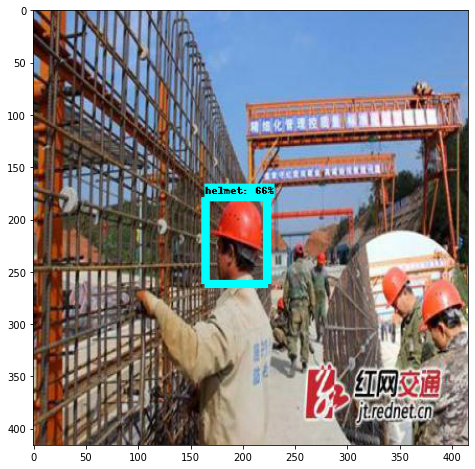

In [ ]:
# Limited displayed images to 5 to reduce memory
count = 5
for i, image_path in enumerate(TEST_IMAGE_PATHS):
    if i > count:
        break
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# 3. Convert

With our model trained, it's time to convert our graph to .tflite!

In [ ]:
%ls /content/models/research/fine_tuned_model/tflite

tflite_graph.pb  tflite_graph.pbtxt


In [ ]:
!tflite_convert \
  --input_shape=1,224,224,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=MobilenetV1/Predictions/Softmax \
  --allow_custom_ops \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_model.tflite"

2021-02-10 16:47:03.585728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-02-10 16:47:03.589025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-10 16:47:03.589382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P4 major: 6 minor: 1 memoryClockRate(GHz): 1.1135
pciBusID: 0000:00:04.0
2021-02-10 16:47:03.589643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-02-10 16:47:03.591224: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-10 16:47:03.592859: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
202

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter('/content/drive/MyDrive/final_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[[ 0.08567557  0.08079338  0.95653296  0.9365697 ]
  [ 0.13488553 -0.0517926   0.91328     0.4659635 ]
  [ 0.10428768  0.39856106  0.90981406  0.9627592 ]
  [ 0.340794    0.00714901  1.0626719   0.54504585]
  [ 0.05285727  0.59681505  0.98544335  0.9998409 ]
  [ 0.88173467  0.04045476  0.9898265   0.11956007]
  [ 0.25225675 -0.1467511   0.7685      0.5518447 ]
  [ 0.17721851  0.1940369   0.9539351   0.75430477]
  [ 0.44016925  0.6050973   0.9381768   1.1250345 ]
  [ 0.4003863   0.14974472  1.1290767   0.87257224]]]


In [ ]:
# Change the final TFLite destination here
!cp /content/models/research/fine_tuned_model/final_model.tflite "/content/drive/My Drive/"

Your TFLite file is now in your Drive as "final_model.tflite", ready to use with your project on-device! For specific device tutorials, check out the official TensorFlow Lite [Android Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), or [Raspberry Pi Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi). [link text](https://)